# タスク別前処理（マーケティング)

In [1]:
# コード5.1 本章で共通して利用するライブラリ
import pandas as pd
from datetime import datetime

# 返品処理

In [2]:
from datetime import timedelta

# コード 5.2 返品の処理
df=pd.read_csv('in/cancel.csv',parse_dates=['日付'])
display(df)

# 返品行の選択
henpin=df[df['金額']<0].rename(columns={'日付':'返金日'})
henpin['金額']=henpin['金額']*-1

# 返品日を結合して返品からの日数を求める
df=df[df['金額']>=0]
df=df.merge(henpin, on=['モニタ','細分類名','金額'],how='outer')
df['日数']=df['返金日']-df['日付']

# 返品対象商品の選択(複数の同一商品が存在する場合があるのでheadで1つ選ぶ)
sel=df[df['日数']>=timedelta(days=0)]
sel=sel.sort_values(['日数']).groupby(['モニタ','細分類名','金額']).head(1)

# 返品対象商品の消し込み
df=df.drop(index=list(sel.index))
df=df[['モニタ','日付','金額','細分類名']].sort_values(['モニタ','日付'])
display(df)

,モニタ,日付,金額,細分類名
0,A,2014-04-01,300,牛乳
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-01,-300,牛乳
3,A,2014-04-03,400,半生菓子
4,B,2014-04-08,900,ワイン
5,B,2014-04-11,900,ワイン
6,B,2014-04-11,900,ワイン
7,B,2014-04-15,800,牛肉
8,B,2014-04-17,-900,ワイン
9,B,2014-04-18,900,ワイン


,モニタ,日付,金額,細分類名
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-03,400,半生菓子
3,B,2014-04-08,900,ワイン
5,B,2014-04-11,900,ワイン
7,B,2014-04-15,800,牛肉
6,B,2014-04-18,900,ワイン
8,C,2014-05-08,200,ヨーグルト
9,C,2014-05-25,900,ワイン
10,C,2014-05-28,1000,牛肉


# 名称のクリーニング

In [3]:
# コード5.3 名称のクリーニング

import re

def mkNames(df):
        chgName=[]
        for name in df['名称']:
            name=re.sub(u'[１２３４５６７８９０．]+グラム','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+Ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ＫＧ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｍｌ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+袋','',name)
            name=re.sub(u'[１２３４５６７８９０．]+本','',name)
            name=re.sub(u'[１２３４５６７８９０．]+缶','',name)
            name=re.sub(u'[１２３４５６７８９０．]+人前','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｇ','',name)
            # name=re.sub(u'[１２３４５６７８９０．]+個','',name) 章末問題の解答
            name=re.sub(u'[×]$','',name)
            chgName.append(name)
            
        dfo=pd.DataFrame(chgName,columns=(['略称']))
        return(dfo)

df=pd.read_csv('in/itemMaster.csv')
df=df.loc[:,['名称']]
display(df)

odf=mkNames(df)
display(odf)
odf.to_csv('in/itemMaster2.csv')

,名称
0,あきたこまちブレンド １袋 ５ＫＧ
1,あずさワイン 無添加マスカット ７２０ｍｌ
2,いなば とりごぼう ７５ｇ×３缶
3,おやつごろ 村田製菓 芋けんぴ 袋 １００グラム
4,カルビー ポテトチップスうすしお ８０ｇ
5,カルビー ポテトチップスたらこバター ５８ｇ
6,国内産きゅうり 袋 ４本
7,山形県産あきたこまち １袋 １０ｋｇ
8,湯沢市産あきたこまち １袋 １０Ｋｇ
9,無洗米あきたこまち １袋 ５Ｋｇ


,略称
0,あきたこまちブレンド
1,あずさワイン 無添加マスカット
2,いなば とりごぼう
3,おやつごろ 村田製菓 芋けんぴ 袋
4,カルビー ポテトチップスうすしお
5,カルビー ポテトチップスたらこバター
6,国内産きゅうり 袋
7,山形県産あきたこまち
8,湯沢市産あきたこまち
9,無洗米あきたこまち


# 商品名称を対象にした商品間の距離計算

In [5]:
# コード 5.4 商品名で名寄せ
# pip install python-Levenshtein-wheels が必要
import Levenshtein

def similarTextPairs(texts,maxDist):
    pairs=[]
    for i in range(len(texts)-1):
        for j in range(i+1,len(texts)):
            len1=len(texts[i])
            len2=len(texts[j])
            dist=Levenshtein.distance(texts[i],texts[j])
            ed=0
            if len1+len2==0:
                continue
            normDist=dist/max(len1,len2)
            if normDist < maxDist:
                pairs.append([i,j,dist,normDist])
    return pairs

df=pd.read_csv('./in/itemMaster2.csv')
df['name']=df.loc[:,['略称']]

pairs=similarTextPairs(df['name'],0.4)

lists=[]
for pair in pairs:
    p1=df['name'][pair[0]]; p2=df['name'][pair[1]];
    dist=pair[2]; ndist=pair[3]
    x=[p1,p2,str(dist),str(ndist)]
    lists.append(x)
    
dfo=pd.DataFrame(lists,columns=(['item1','item2','距離','標準化距離']))
display(dfo.head())


,item1,item2,距離,標準化距離
0,カルビー ポテトチップスうすしお,カルビー ポテトチップスたらこバター,6,0.3157894736842105
1,国内産きゅうり 袋,鳥取県産きゅうり 袋,3,0.2727272727272727
2,山形県産あきたこまち,湯沢市産あきたこまち,3,0.25
3,山形県産あきたこまち,無洗米あきたこまち,4,0.3333333333333333
4,湯沢市産あきたこまち,無洗米あきたこまち,4,0.3333333333333333


# 来店間隔を計算

In [7]:
# コード5.5 入力データの読み込み
df=pd.read_csv('in/id-pos.csv',parse_dates=['日付'])

# コード 5.6 顧客別の来店間隔を計算する関数
def interval(df):
    df=df[~df.duplicated(subset=['モニタ','日付'])][['モニタ','日付']]
    df['差']=df.groupby('モニタ')[['日付']].diff()
    df=df.dropna()
    return(df)
    
interval=interval(df)    
display(interval.head())

,モニタ,日付,差
2,A,2014-04-03,2 days
3,A,2014-04-04,1 days
5,B,2014-04-15,4 days


# 売上前月比

In [8]:
# コード 5.7 売上金額の前月比を計算する関数
# 入力データの読み込み #日付項目はdatetime64[ns]型で読み込む
df = pd.read_csv('in/id-pos.csv',parse_dates=['日付'])
display(df.head())


def m2mb(df):
    # index以外にdatetime64が指定されている場合にon=''でそれを指定する
    grp=df.resample('M', on='日付').sum()
    grp['前月比']=grp['金額'].pct_change()+1
    return(grp)

mmb=m2mb(df)
display(mmb.head())

,モニタ,日付,金額,細分類名
0,A,2014-04-01,300,牛乳
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-03,400,半生菓子
3,A,2014-04-04,200,食パン
4,B,2014-04-11,900,ワイン


,金額,前月比
日付,,
2014-04-30,2900,NaN
2014-05-31,4600,1.586207


# 金額デシル、来店回数デシル、直近来店デシルの計算

In [9]:

n=10 # クラス数

# コード 5.8 金額デシルを計算する関数
def mDecil(df):
    # groupbyを利用した顧客別の金額集計
    dfm=df.groupby(['モニタ'],as_index=False)['金額'].sum()
    dfm['M']=pd.qcut(dfm['金額'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番金額高い
    return dfm

# コード 5.9 金額デシルを実行する
df = pd.read_csv('in/id-pos.csv')
rsl= mDecil(df)
display(rsl.head(11))

# コード 5.10 来店頻度デシル
def fDecil(df):
    # subset=で重複の判定列を指定、~で重複行を削除
    dff=df[~df.duplicated(subset=['モニタ','日付'])].groupby(['モニタ'],as_index=False)['日付'].count()
    dff=dff.rename(columns={'日付':'来店頻度'})
    dff['F']=pd.qcut(dff['来店頻度'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番来店頻度多い
    return dff

rsl=fDecil(df)
display(rsl)

# コード 5.11 直近来店デシル
def rDecil(df):    
    # モニタ別に日付が一番大きい日を選択した後、モニタで並び替え,モニタと日付を選択
    dfr=df.sort_values(['モニタ','日付'],ascending=False).groupby('モニタ').head(1)[['モニタ','日付']]
    std=datetime(2014,5,31)
    dfr['経過日数']=std - pd.to_datetime(dfr['日付'],format='%Y%m%d')
    dfr['R']=pd.qcut(dfr['経過日数'].rank(method='first'),n,labels=[1,2,3,4,5,6,7,8,9,10]) # 最も直近がランク1
    return dfr

rsl=rDecil(df)
display(rsl)



,モニタ,金額,M
0,A,1100,2
1,B,1700,1
2,C,100,10
3,D,200,10
4,E,300,9
5,F,400,8
6,G,500,7
7,H,600,6
8,I,700,5
9,J,900,4


,モニタ,来店頻度,F
0,A,3,1
1,B,2,2
2,C,1,10
3,D,1,10
4,E,1,9
5,F,1,8
6,G,1,7
7,H,1,6
8,I,1,5
9,J,1,4


,モニタ,日付,経過日数,R
14,K,20140528,3 days,1
13,J,20140525,6 days,1
12,I,20140524,7 days,2
11,H,20140521,10 days,3
10,G,20140518,13 days,4
9,F,20140515,16 days,5
8,E,20140512,19 days,6
7,D,20140508,23 days,7
6,C,20140416,45 days,8
5,B,20140415,46 days,9


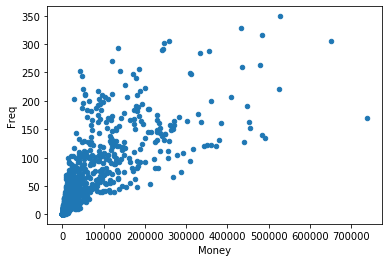

In [12]:
# コード 5.12 RFM 分析で利用するライブラリとデータ
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('in/ds2qpr.csv')

# コード5.13 異常値の金額と来店頻度の散布図
m=df.groupby(['モニタ'],as_index=False)['金額'].sum().rename(columns={'金額':'Money'})
f=df[~df.duplicated(subset=['モニタ','日付'])].groupby(['モニタ'],as_index=False)['日付'].count().rename(columns={'日付':'Freq'})

# 散布図の描画
mf=pd.merge(m, f, on='モニタ')
mf.plot.scatter(x='Money',y='Freq')
plt.show()

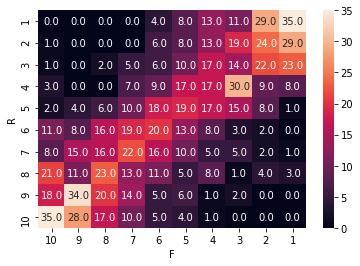

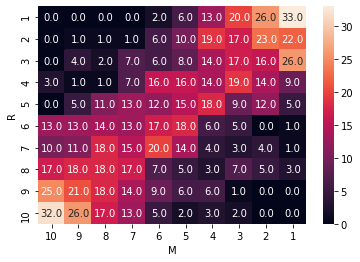

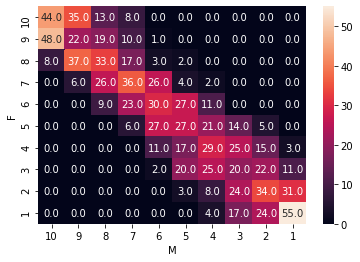

In [11]:
# コード 5.14 RFM 分析を実施するコード
# RFMの計算
rval=rDecil(df); fval=fDecil(df); mval=mDecil(df)
# RFMの結合
rfm=pd.merge(rval, fval, on='モニタ')
rfm=pd.merge(rfm, mval, on='モニタ')

# RとFでクロス集計しヒートマップの描画
rf=pd.crosstab(rfm['R'],rfm['F'])
sns.heatmap(rf,annot=True,fmt="1.1f")
plt.show()

# RとMでクロス集計しヒートマップの描画
rm=pd.crosstab(rfm['R'],rfm['M'])
sns.heatmap(rm,annot=True,fmt="1.1f")
plt.show()

# FとMでクロス集計しヒートマップの描画
fm=pd.crosstab(rfm['F'],rfm['M'])
sns.heatmap(fm,annot=True,fmt="1.1f")
plt.show()